In [103]:
# tools
import numpy as np
import pandas as pd

import re
import tldextract

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import joblib
import shutil
import subprocess
import os

import sys
sys.path.append( '../resource')
from tld import country_tld, original_tld


In [104]:
# PHISING = 1
# LEGET = 0
pd.set_option('future.no_silent_downcasting', True)

In [129]:
# df1
df1 = pd.read_csv('../resource/dataset_aalto.csv')
df1 = df1.rename(columns={'domain': 'URL', 'label': 'Label'})
df1 = df1[['URL', 'Label']]
df1['Label'] = df1['Label'].dropna().apply(str).replace({'1.0': 1, '0.0': 0})
print('Phishing URL percentage fo df1: ', (df1['Label']==1).sum()/len(df1['Label']))
print('Datapoints of df1: ', len(df1['Label']))

df1.head(3)

Phishing URL percentage fo df1:  0.4994369839019101
Datapoints of df1:  95912


C:\Users\LAPTOP\AppData\Local\Temp\ipykernel_19416\1570866052.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('../resource/dataset_aalto.csv')


,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1


In [130]:
# df2
df2 = pd.read_csv('../resource/dataset_uci.csv')
df2 = df2.rename(columns={'url': 'URL', 'label': 'Label'})
df2 = df2[['URL', 'Label']]
df2['Label'] = df2['Label'].replace({1: 0, 0: 1}).infer_objects(copy=False)
print('Phishing URL percentage fo df2: ', (df2['Label']==1).sum()/len(df2['Label']))
print('Datapoints of df2: ', len(df2['Label']))
df2.head(3)

Phishing URL percentage fo df1:  0.42810492164804176
Datapoints of df1:  235795


,URL,Label
0,https://www.southbankmosaics.com,0
1,https://www.uni-mainz.de,0
2,https://www.voicefmradio.co.uk,0


In [131]:
# df3
df3 = pd.read_csv('../resource/dataset_mendeley_1.csv')
df3 = df3.rename(columns={'url': 'URL', 'Type': 'Label'})
df3['Label'] = df3['Label'].replace({'Phishing': 1}).infer_objects(copy=False)
df3 = df3[['URL', 'Label']]
print('Phishing URL percentage fo df3: ', (df3['Label']==1).sum()/len(df3['Label']))
print('Datapoints of df3: ', len(df3['Label']))
df3.head(3)

Phishing URL percentage fo df3:  1.0
Datapoints of df3:  54807


,URL,Label
0,https://docs.google.com/presentation/d/e/2PACX...,1
1,https://btttelecommunniccatiion.weeblysite.com/,1
2,https://kq0hgp.webwave.dev/,1


In [132]:
# df4
df4 = pd.read_csv('../resource/dataset_mendeley_2.csv')
df4 = df4.rename(columns={'url': 'URL', 'type': 'Label'})
df4['Label'] = df4['Label'].replace({'legitimate': 0, 'phishing': 1}).infer_objects(copy=False)
df4 = df4[['URL', 'Label']]
print('Phishing URL percentage fo df4: ', (df4['Label']==1).sum()/len(df4['Label']))
print('Datapoints of df4: ', len(df4['Label']))
df4.head(3)

Phishing URL percentage fo df4:  0.23199370912709696
Datapoints of df4:  450176


,URL,Label
0,https://www.google.com,0
1,https://www.youtube.com,0
2,https://www.facebook.com,0
3,https://www.baidu.com,0
4,https://www.wikipedia.org,0
...,...,...
450168,http://boasecg7.beget.tech/cgi-bin/index/pcg/f...,1
450169,http://gangainsulations.com/alert/GD/,1
450170,https://qiumin.xyz/qiuminxy/o95j4uW4nr/5.php,1
450171,http://ecct-it.com/docmmmnn/aptgd/index.php,1


In [140]:
# df5
df5 = pd.read_csv('../resource/dataset_phishtank.csv')
df5 = df5[df5['verified'] == 'yes']
df5 = df5.rename(columns={'url': 'URL'})
df5['Label'] = 1
df5 = df5[['URL', 'Label']]
print('Phishing URL percentage fo df5: ', (df5['Label']==1).sum()/len(df5['Label']))
print('Datapoints of df5: ', len(df5['Label']))
df5.head(3)

Phishing URL percentage fo df5:  1.0
Datapoints of df5:  90785


,URL,Label
0,https://www.ingmovil-login.com/,1
1,https://www.yffm.cn,1
2,https://www.wgcw.cn,1


In [142]:
# concat df
df = pd.concat([df1, df2, df3, df4, df5], axis=0)
df = df.dropna()
df['Label'] = df['Label'].astype(int)
df['URL'] = df['URL'].astype(str)
df['URL'] = df['URL'].str.replace(r'^\d+', '', regex=True)
df['URL'] = df['URL'].str.replace(r'^www\.', '', regex=True)
df['URL'] = df['URL'].str.replace('://www.', '://')
df = df.drop_duplicates(subset=['URL'])
print('Phishing URL percentage fo df: ', (df['Label']==1).sum()/len(df['Label']))
print('Datapoints of df: ', len(df['Label']))
df.head(3)

Phishing URL percentage fo df:  0.4060230192689386
Datapoints of df:  889255


,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1
1,dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd=_...,1
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1


In [143]:
# helper methods
def strip_https(url): return url.replace(r'^www\.', '').replace('://www.', '://').replace('http://', '').replace('https://', '')

def has_http(url):
    return 1 if 'http://' in url else 0

def has_original_tld(url):
    url = strip_https(url)
    extracted = tldextract.extract(url)
    tld = extracted.suffix
    result = [x in original_tld for x in tld.split('.')]
    return 1 if any(result) else 0

def has_country_tld(url):
    url = strip_https(url)
    extracted = tldextract.extract(url)
    tld = extracted.suffix
    result = [x in country_tld for x in tld.split('.')]
    return 1 if any(result) else 0

def extract_subdir_TLD(url):
    url = strip_https(url)
    splitted = re.split(r'(?<!/)/(?!/)', url)
    return 1 if any('.' in part for part in splitted[1:]) else 0

def count_www_outside_domain(url):
    url = strip_https(url)
    splitted = re.split(r'(?<!/)/(?!/)', url)
    return sum(1 for part in splitted[1:] if 'www' in part)

def count_subdomain(url):
    url = strip_https(url)
    extracted = tldextract.extract(url)
    return 0 if len(extracted.subdomain) == 0 else extracted.subdomain.count('.') + 1

def letter_ratio(url):
    url = strip_https(url)
    splitted = list(url)
    letter = 0
    total = 0
    for char in splitted:
        if char.isalpha():
            letter += 1
        total += 1
    return 0 if total == 0 else letter/total

def digit_ratio(url):
    url = strip_https(url)
    splitted = list(url)
    digit = 0
    total = 0
    for char in splitted:
        if char.isdigit():
            digit += 1
        total += 1
    return 0 if total == 0 else digit/total

def non_alnum_ratio(url):
    url = strip_https(url)
    splitted = list(url)
    non_alnum = 0
    total = 0
    for char in splitted:
        if not char.isalnum():
            non_alnum += 1
        total += 1
    return 0 if total == 0 else non_alnum/total

def extract_suffix(url):
    url = url.lower()
    extracted = tldextract.extract(url)
    suffix = extracted.suffix
    return suffix.split('.')[-1]

In [144]:
# helper methods' tests
def test_has_http():
    assert has_http('http://example.com') == 1
    assert has_http('https://example.org') == 0
    assert has_http('example.xyz') == 0

def test_has_original_tld():
    assert has_original_tld('http://example.com') == 1
    assert has_original_tld('http://example.org') == 1
    assert has_original_tld('http://example.xyz') == 0
    print("test_has_original_tld passed")

def test_has_country_tld():
    assert has_country_tld('http://example.co.uk') == 1
    assert has_country_tld('http://example.fr') == 1
    assert has_country_tld('http://example.xyz') == 0
    print("test_has_country_tld passed")

def test_extract_subdir_TLD():
    assert extract_subdir_TLD('http://example.com/path.to.resource') == 1
    assert extract_subdir_TLD('http://example.com/') == 0
    assert extract_subdir_TLD('http://example.com/') == 0
    print("test_extract_subdir_TLD passed")

def test_count_www_outside_domain():
    assert count_www_outside_domain('http://www.example.com/www/www/dfaf.www/dsasdasd/www.wasdasd') == 4
    assert count_www_outside_domain('http://example.com') == 0
    assert count_www_outside_domain('http://www.test.www.example.com') == 0
    print("test_count_www_outside_domain passed")

def test_count_subdomain():
    assert count_subdomain('http://sub.example.com') == 1
    assert count_subdomain('http://example.com') == 0
    assert count_subdomain('http://sub1.sub2.example.com') == 2
    print("test_count_subdomain passed")

def test_letter_ratio():
    assert letter_ratio("http://example.com/path?query=1") == 19/24
    assert letter_ratio("!@#$%^&*()") == 0
    assert letter_ratio("") == 0 
    assert letter_ratio("wertyuiop") == 1
    print("test_letter_ratio passed")

def test_digit_ratio():
    assert digit_ratio("http://example.com/path?query=1") == 1/24
    assert digit_ratio("12345") == 1
    assert digit_ratio("!@#$%^&*()") == 0 
    assert digit_ratio("") == 0 
    print("test_digit_ratio passed")

def test_non_alnum_ratio():
    assert non_alnum_ratio('http://example.com') == 1/11 
    assert non_alnum_ratio('http://example.com?query=1') > 0 
    assert non_alnum_ratio('!@#$%^&*()') == 1 
    print("test_non_alnum_ratio passed")

def test_extract_suffix():
    assert non_alnum_ratio('http://example.com') == ['com']
    assert non_alnum_ratio('http://example.com?query=1') == ['com']
    assert non_alnum_ratio('http://example.com.vn') == [ 'vn'] 

In [145]:
# run helper methods' tests
test_has_http()
test_has_original_tld()
test_has_country_tld()
test_extract_subdir_TLD()
test_count_www_outside_domain()
test_count_subdomain()
test_letter_ratio()
test_digit_ratio()
test_non_alnum_ratio()

test_has_original_tld passed
test_has_country_tld passed
test_extract_subdir_TLD passed
test_count_www_outside_domain passed
test_count_subdomain passed
test_letter_ratio passed
test_digit_ratio passed
test_non_alnum_ratio passed


In [146]:
df['suffix'] = df['URL'].apply(extract_suffix)
df = df[df['suffix'] != '']
tld_df = pd.DataFrame(df.groupby(['Label', 'suffix'])['URL'].count()).reset_index()
tld_df['label_count'] = tld_df['Label'] * tld_df['URL']
tld_df = tld_df.groupby('suffix').agg({ 'URL': 'sum', 'label_count': 'sum' }).reset_index()
tld_df['TLD_credibility'] = tld_df['label_count'] / tld_df['URL']
tld_df['TLD_relative_popularity'] = tld_df['URL'] / tld_df['URL'].sum()
tld_df = tld_df[['suffix', 'TLD_relative_popularity', 'TLD_credibility' ]]
tld_df.head(3)

,suffix,TLD_relative_popularity,TLD_credibility
0,ac,0.000072,0.546875
1,academy,0.000026,0.826087
2,accountant,0.000002,1.000000


In [147]:
# extract features
df = df.copy()
df = df.drop_duplicates(subset=['URL'])
df = pd.merge(df, tld_df, on='suffix', how='inner')
df['Label'] = df['Label'].replace({'bad': 1, 'phishing': 1, 'good': 0, 'legitimate': 0}).infer_objects(copy=False)
df['Length'] = df['URL'].map(len)
df['Dot_count'] = df['URL'].str.count(r'\.')
df['At_count'] = df['URL'].str.count(r'\@')
df['Perc_count'] = df['URL'].str.count(r'%')
df['Dash_count'] = df['URL'].str.count(r'_')
df['Has_http'] = df['URL'].map(has_http)
df['Has_original_TLD'] = df['URL'].map(has_original_tld)
df['Has_country_TLD'] = df['URL'].map(has_country_tld)
df['Subdirectory_contains_TLD'] = df['URL'].map(extract_subdir_TLD)
df['Letter_ratio'] = df['URL'].map(letter_ratio)
df['Digit_ratio'] = df['URL'].map(digit_ratio)
df['Num_of_subdomain'] = df['URL'].map(count_subdomain)
df['Num_of_www_outside_domain'] = df['URL'].map(count_www_outside_domain)
df['Non_alnum_ratio'] = df['URL'].map(non_alnum_ratio)
df.head(3)

,URL,Label,suffix,TLD_relative_popularity,TLD_credibility,Length,Dot_count,At_count,Perc_count,Dash_count,Has_http,Has_original_TLD,Has_country_TLD,Subdirectory_contains_TLD,Letter_ratio,Digit_ratio,Num_of_subdomain,Num_of_www_outside_domain,Non_alnum_ratio
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1,it,0.004536,0.470808,225,6,0,0,4,0,0,1,1,0.600000,0.257778,0,0,0.142222
1,dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd=_...,1,com,0.583680,0.305228,77,4,0,0,1,0,1,0,1,0.805195,0.012987,0,0,0.181818
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1,com,0.583680,0.305228,177,7,0,0,0,0,1,0,1,0.627119,0.265537,0,0,0.107345
3,mail.printakid.com/www.online.americanexpress....,1,com,0.583680,0.305228,60,6,0,0,0,0,1,0,1,0.866667,0.000000,1,1,0.133333
4,thewhiskeydregs.com/wp-content/themes/widescre...,1,com,0.583680,0.305228,116,1,0,0,0,0,1,0,0,0.706897,0.181034,0,0,0.112069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883638,https://mailorange6.godaddysites.com/,1,com,0.583680,0.305228,37,2,0,0,0,0,1,0,0,0.862069,0.034483,1,0,0.103448
883639,https://orange69.godaddysites.com/,1,com,0.583680,0.305228,34,2,0,0,0,0,1,0,0,0.807692,0.076923,1,0,0.115385
883640,https://orangefr.godaddysites.com/,1,com,0.583680,0.305228,34,2,0,0,0,0,1,0,0,0.884615,0.000000,1,0,0.115385
883641,https://accueilorange.godaddysites.com/,1,com,0.583680,0.305228,39,2,0,0,0,0,1,0,0,0.903226,0.000000,1,0,0.096774


In [174]:
# correlation between label and features
absolute_corr = df.drop(columns=['URL', 'suffix']).corr().map(abs).round(2)
absolute_corr['Label'].sort_values(ascending=False)

Label                        1.00
Has_http                     0.54
TLD_credibility              0.53
Has_original_TLD             0.38
Dot_count                    0.28
Num_of_subdomain             0.27
TLD_relative_popularity      0.25
Has_country_TLD              0.22
Digit_ratio                  0.21
Letter_ratio                 0.20
Length                       0.13
Num_of_www_outside_domain    0.09
At_count                     0.08
Dash_count                   0.06
Subdirectory_contains_TLD    0.05
Perc_count                   0.03
Non_alnum_ratio              0.01
Name: Label, dtype: float64

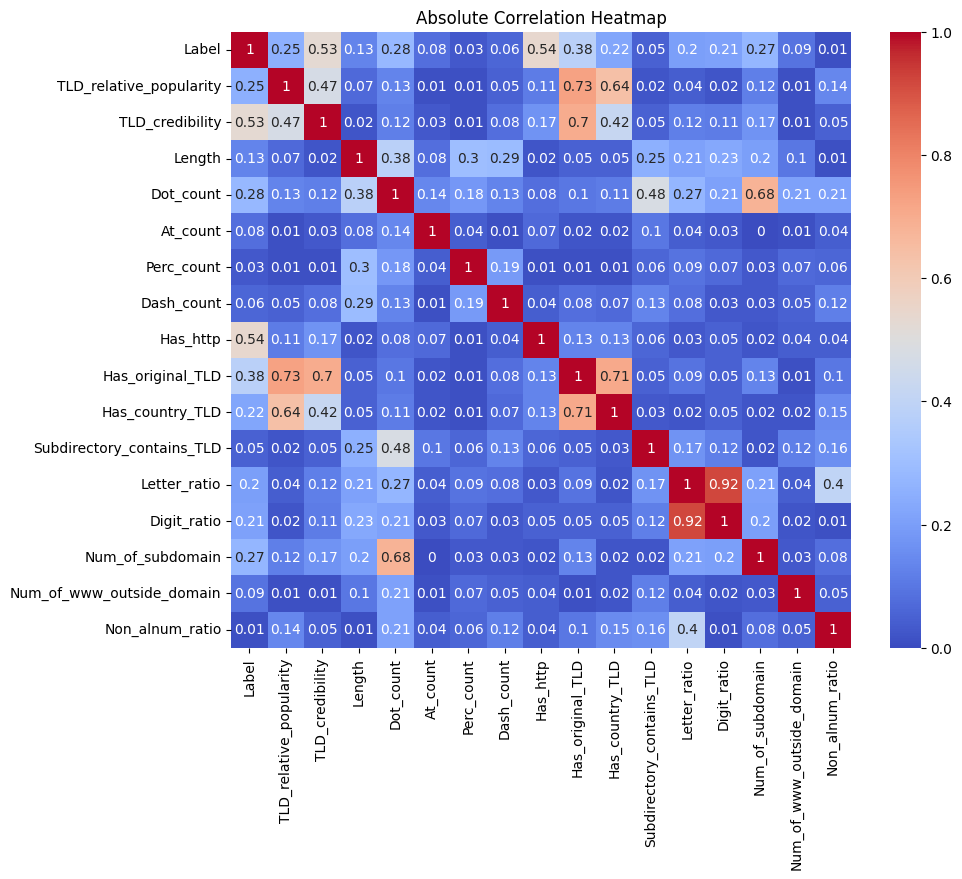

In [175]:
# absolute correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(absolute_corr, annot=True, cmap='coolwarm')
plt.title('Absolute Correlation Heatmap')
plt.show()

In [150]:
# prepare data
X = df.drop(columns=['Label', 'URL', 'suffix'])
y = df['Label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [151]:
# random forest classifier
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
rf_classifier.fit(X_train, y_train)
threshold = 0.2
y_pred = rf_classifier.predict_proba(X_val)
y_pred = np.where(y_pred[:, 1] > threshold, 1, 0)

In [172]:
# accuracy, precision and recall score
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy Score: {accuracy}')
precision = precision_score(y_val, y_pred)
print(f'Precision Score: {precision}')
recall = recall_score(y_val, y_pred)
print(f'Recall Score: {recall}')

Accuracy Score: 0.926582507681252
Precision Score: 0.8746012681931477
Recall Score: 0.9540063109257902


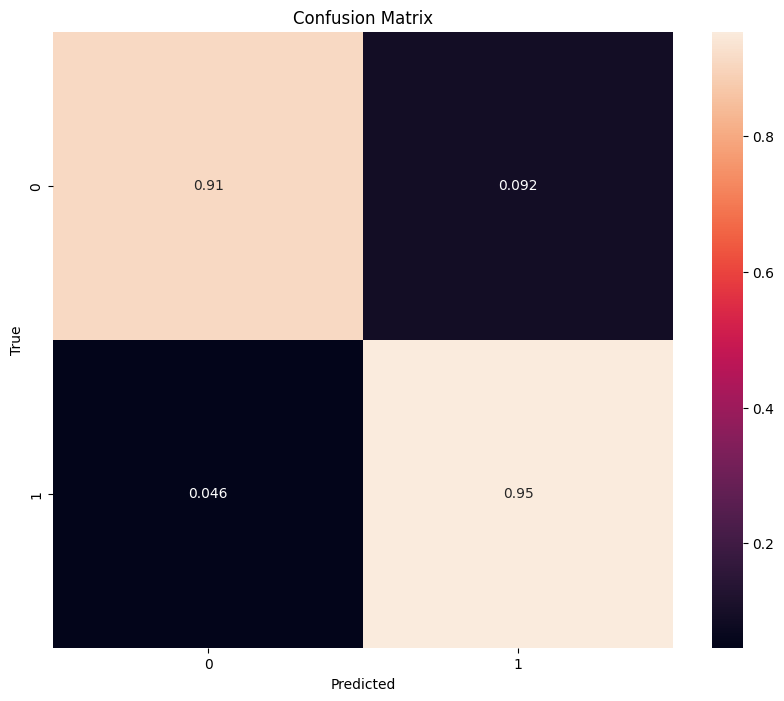

In [173]:
#confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [154]:
joblib.dump(rf_classifier, 'model.pkl')

['model.pkl']

In [155]:
# export
# initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]
# onnx_model = skl2onnx.convert_sklearn(rf_classifier, initial_types=initial_type, options={'zipmap': False})
# with open('model.onnx', 'wb') as f:
#     f.write(onnx_model.SerializeToString())

In [156]:
#move model
source_file = 'model.pkl'
destination_directory = '../phishing-detector'
shutil.copy(source_file, destination_directory)
subprocess.run(['icacls', os.path.join(destination_directory, 'model.pkl'), '/grant', 'Everyone:(R)'], check=True)

CompletedProcess(args=['icacls', '../phishing-detector\\model.pkl', '/grant', 'Everyone:(R)'], returncode=0)